## Add Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Change Directory

In [ ]:
cd drive/MyDrive/Cell_Segmentation/

/content/drive/.shortcut-targets-by-id/1G4g4EEAxBetJGDFuV6HWSC2f_sCXw0mN/Cell_Segmentation


## Install Packages

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.9 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Imports

In [ ]:
import numpy as np
import enum
import albumentations as A

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim


# import datasets
from my_datasets import LISC
from my_datasets import WBC
from my_datasets import CELLAVISION
from my_utils.splitdata import split_data


# import expriments 
from my_utils.expriments import train_model
from my_utils.expriments import test_model

# import metrics
from my_utils.metrics import dice_coefficients 
from my_utils.metrics import iou
from my_utils.metrics import precision
from my_utils.metrics import recall

# import Visualization
from my_utils.Visualization import show_prediction

# import model
from my_models import CustomModel

# import loss
from my_losses import MultiTaskLoss



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define DataSets Properties

In [ ]:
class BloodDatasets(enum.Enum):
    WBCDATASET1 = 1
    WBCDATASET2 = 2
    LISC = 3
    CELLAVISION = 4

In [ ]:
dataset_info = {
    BloodDatasets.WBCDATASET1 : {
        'name' : 'WBC_DATASET1',
        'image_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/WBC/Dataset 1/Images',
        'mask_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/WBC/Dataset 1/Masks',
        'data_set' : WBC
    },
    BloodDatasets.WBCDATASET2 : {
        'name' : 'WBC_DATASET2',
        'image_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/WBC/Dataset 2/Images',
        'mask_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/WBC/Dataset 2/Masks',
        'data_set' : WBC
    }, 
    BloodDatasets.LISC : {
        'name' : 'LISC_DATASET',
        'image_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/LISC/Main Dataset',
        'mask_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/LISC/Ground Truth Segmentation',
        'data_set' : LISC
    },
    BloodDatasets.CELLAVISION : {
        'name' : 'CELLAVISION_DATASET',
        'image_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/CellaVision/IDB1/images',
        'mask_dir' : '/content/drive/MyDrive/Cell_Segmentation/Data/CellaVision/IDB1/labels',
        'data_set' : CELLAVISION
    }
}

## Select DataSet and Define Aug Functions

In [ ]:
ds = BloodDatasets.CELLAVISION
dataset = dataset_info[ds]['data_set']
aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.5, alpha_affine=120 * 0.003, p=0.5),
        A.GridDistortion(p=0.5),                
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)
    ])
batch_size = 16
target_size = (256,256)

data = split_data(dataset_info[ds]['image_dir'], dataset_info[ds]['mask_dir'], 0.2, 0.2, dataset_info[ds]['name']) #data = {'Train': train_set, 'Validation': val_set, 'Test': test_set }

## Define DataSet and DataLoader

In [ ]:
my_datasets = {x: dataset(dataset_info[ds]['image_dir'],
                      dataset_info[ds]['mask_dir'],
                      transforms=aug if x=='Train' else None,
                      for_data=x,
                      target_size=target_size,
                      file_names=data[x])
                                  
                  for x in ['Train','Test', 'Validation']}

my_dataloaders = {x: DataLoader(my_datasets[x], 
                                batch_size= 1 if x=='Test' else batch_size,
                                shuffle=True if x=='Train' else None)
                                  
                  for x in ['Train','Test', 'Validation']}


num_data = {'Train':len(my_datasets['Train']), 'Validation':len(my_datasets['Validation']), 'Test': len(my_datasets['Test'])}

## Show Sample of Data

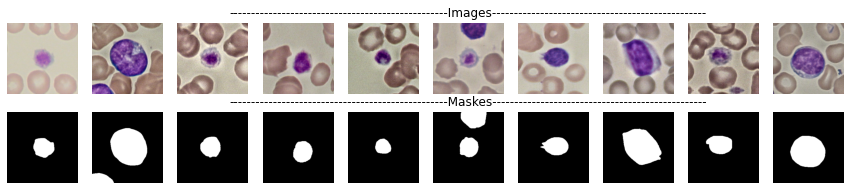

In [ ]:
my_datasets['Train'].show_samples(10)

## Print Number of Train, Test and Validation Image

In [ ]:
print(my_datasets['Train'])
print(my_datasets['Test'])
print(my_datasets['Validation'])

The CELLAVISION Dataset is Selected for Train. Number of Train Data is: 89 
The CELLAVISION Dataset is Selected for Test. Number of Test Data is: 29 
The CELLAVISION Dataset is Selected for Validation. Number of Validation Data is: 29 


## Define Model, Loss, Optimizer and Scheduler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'D4_unet+CA'
max_epoch = 100
n_channels = 3
n_classes = 2
bilinear = True
multi_task = False
SA_F = False
CA_F = True

model = CustomModel(n_channels = n_channels,
                    n_classes = n_classes,
                    bilinear = bilinear,
                    multi_task = multi_task,
                    SA_F = SA_F,
                    CA_F = CA_F).to(device)
if multi_task:
    criterion = MultiTaskLoss(alpha=0.99).to(device)
else:
    criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9 , weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=max_epoch)

## Show Model

In [ ]:
print(model)

CustomModel(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05,

## Train the Model


-------training mode is on CUDA-------

Best Validation Dice: 0.972668


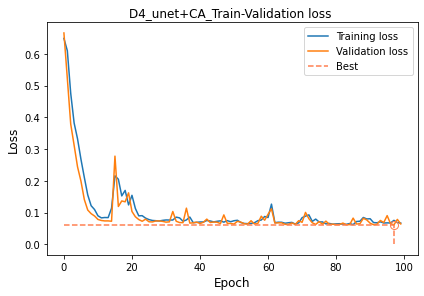

In [ ]:
model = train_model(model = model,
                    dataloaders = my_dataloaders,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    num_data = num_data,
                    val_step = 1,
                    scheduler = scheduler,
                    max_epoch = max_epoch,
                    model_name = model_name,
                    multi_task = multi_task)
torch.save(model.state_dict(), f'pth_files/{model_name}.pth')

## Test the Model

In [ ]:
path_result = '/content/drive/MyDrive/Cell_Segmentation/Results'
data_loader = my_dataloaders['Test']
num_data = len(my_datasets['Test'])
eval_metrics = [dice_coefficients, iou, precision, recall]

state_dict = torch.load(f'pth_files/{model_name}.pth')
model.load_state_dict(state_dict)


results = test_model(model,
                     data_loader,
                     num_data, 
                     device,
                     path_result,
                     eval_metrics,
                     model_name)


Test is in process....



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Show Predicted Image (First Col: Orginal Image, Second Col: Grand Truth, Third Col: Predicted) 

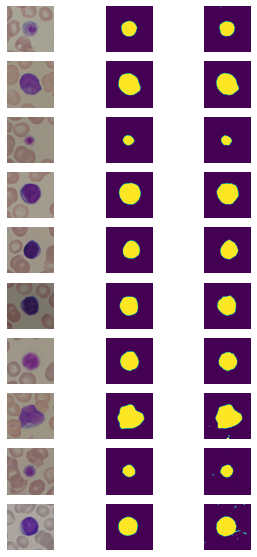

In [ ]:
show_prediction(model, data_loader, device, 10)

## Calculate Dice, Iou, Precision, Recall

In [ ]:
list_temp = []
print(f'Model is: {model_name}\n')
for each_metric in eval_metrics:
    temp = results[each_metric.__name__]
    list_temp=[]
    for key, value in temp.items(): 
        list_temp.append(value)
    arrays = [np.array(x) for x in list_temp]
    if each_metric.__name__ == 'dice_coefficients':
        result = [np.mean(k) for k in zip(*list_temp)]
    else:
        result = np.mean(list_temp)
    print(f'{each_metric.__name__} :  {np.mean(result)}')


Model is: D4_unet+CA

dice_coefficients :  0.9693484606114353
iou :  0.9426549176502613
precision :  0.9501152905527437
recall :  0.956062890523548


In [ ]:
list_temp = []
print(f'Model is: {model_name}\n')
for each_metric in eval_metrics:
    temp = results[each_metric.__name__]
    list_temp=[]
    for key, value in temp.items(): 
        list_temp.append(value)
    arrays = [np.array(x) for x in list_temp]
    if each_metric.__name__ == 'dice_coefficients':
        result = [np.mean(k) for k in zip(*list_temp)]
    else:
        result = np.mean(list_temp)
    print(f'{each_metric.__name__} :  {np.mean(result)}')


Model is: D4_unet+CA

dice_coefficients :  0.9693484606114353
iou :  0.9426549176502613
precision :  0.9501152905527437
recall :  0.956062890523548


In [ ]:
list_temp = []
print(f'Model is: {model_name}\n')
for each_metric in eval_metrics:
    temp = results[each_metric.__name__]
    list_temp=[]
    for key, value in temp.items(): 
        list_temp.append(value)
    arrays = [np.array(x) for x in list_temp]
    if each_metric.__name__ == 'dice_coefficients':
        result = [np.mean(k) for k in zip(*list_temp)]
    else:
        result = np.mean(list_temp)
    print(f'{each_metric.__name__} :  {np.mean(result)}')


Model is: D4_unet+CA

dice_coefficients :  0.9693484606114353
iou :  0.9426549176502613
precision :  0.9501152905527437
recall :  0.956062890523548


In [ ]:
list_temp = []
print(f'Model is: {model_name}\n')
for each_metric in eval_metrics:
    temp = results[each_metric.__name__]
    list_temp=[]
    for key, value in temp.items(): 
        list_temp.append(value)
    arrays = [np.array(x) for x in list_temp]
    if each_metric.__name__ == 'dice_coefficients':
        result = [np.mean(k) for k in zip(*list_temp)]
    else:
        result = np.mean(list_temp)
    print(f'{each_metric.__name__} :  {np.mean(result)}')


Model is: Unet+CA+SA+MT

dice_coefficients :  0.9703965321244965
iou :  0.9066666666666666
precision :  0.9559848435388708
recall :  0.9679104276451653


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import traces

In [ ]:
x_data = ['Henrik Sedin', 'Daniel Sedin',
          'Brock Boeser', 'Elias Pettersen',
          'Bo Horvat', 'Pavel Bure',]

# Generate random data
y0 = np.random.randn(50)+4
y1 = np.random.randn(50)+4
y2 = np.random.randn(50)+2
y3 = np.random.randn(50)+2
y4 = np.random.randn(50)+1
y5 = np.random.randn(50)+3
y_data = [y0,y1,y2,y3,y4,y5]
df = pd.DataFrame(y_data)
vmin, vmax = df.min().min(), df.max().max()

In [ ]:
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = matplotlib.cm.get_cmap('GnBu') # green to blue color way

In [ ]:
for xd, yd in zip(x_data, y_data):
        traces =[]
        median = np.median(yd) # find the median
        color = 'rgb' + str(cmap(norm(median))[0:3]) # normalize

        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,      # add the box plot color
            marker=dict(
                size=2,
            ),
            line=dict(width=1)
        ))

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
x_data = ['Henrik Sedin', 'Daniel Sedin',
          'Brock Boeser', 'Elias Pettersen',
          'Bo Horvat', 'Pavel Bure',]
y0 = np.random.randn(50)+4
y1 = np.random.randn(50)+4
y2 = np.random.randn(50)+2
y3 = np.random.randn(50)+2
y4 = np.random.randn(50)+1
y5 = np.random.randn(50)+3
y_data = [y0,y1,y2,y3,y4,y5]
traces = []
df = pd.DataFrame(y_data)
vmin, vmax = df.min().min(), df.max().max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = matplotlib.cm.get_cmap('GnBu')
for xd, yd in zip(x_data, y_data):
        median = np.median(yd)
        color = 'rgb' + str(cmap(norm(median))[0:3])
        
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker=dict(
                size=2,
                color='rgb(0, 0, 0)'
            ),
            line=dict(width=1),
        ))
layout = go.Layout(
    title='Canucks all time +/- per game',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    shapes= [{
      'type': 'line',
      'x0': -1,
      'y0': 2,
      'x1': 6,
      'y1': 2,
      'line': {
        'color': 'rgb(50, 171, 96)',
        'width': 4,
        'dash': 'dashdot'
      }
    }]
)
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [ ]:
import torchvision.models as models

In [ ]:
import torch
import torch.nn as nn

In [ ]:
data = torch.rand((1,3, 21, 21))

In [ ]:
model = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
model.fc = nn.Identity()

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output1 = m(input)
 # target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output2 = m(input)
 # target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output3 = m(input)

In [ ]:
print(output1.shape)

torch.Size([1, 64, 5, 7])


In [ ]:
import torch

In [ ]:
torch.__version__

'1.9.0+cu102'